### A plain language guide to modularization

In [ ]:
fuel_elec_mmbtu_cols = index_cols + [col for col in pr_gen_fuel.columns if "fuel_consumed_for_electricity_mmbtu" in col]
fuel_elec_mmbtu = pr_gen_fuel.loc[:, fuel_elec_mmbtu_cols]

## Melt the fuel_consumed columns
fuel_elec_mmbtu_melt = fuel_elec_mmbtu.melt(
    id_vars=index_cols,
    var_name="month",
    value_name="fuel_consumed_for_electricity_mmbtu"
)
fuel_elec_mmbtu_melt["month"] = fuel_elec_mmbtu_melt["month"].str.replace("fuel_consumed_for_electricity_mmbtu_", "")
fuel_elec_mmbtu_melt = fuel_elec_mmbtu_melt.set_index(index_cols + ["month"])
fuel_elec_mmbtu_melt

What does this code do?

*This code takes a table with data stored in one column per month and stacks all the fields for a single variable (fuel_consumed_for_electricity_mmbtu), returning a table with one month column and one value column for this variable in order to make it easier to plot our data over time.*

In [ ]:
# Pivot net_generation columns
net_gen_cols = index_cols + [col for col in pr_gen_fuel.columns if col.startswith("net_generation_mwh")]
net_gen = pr_gen_fuel.loc[:, net_gen_cols]

## Melt the fuel_consumed columns
net_gen_melt = net_gen.melt(
    id_vars=index_cols,
    var_name="month",
    value_name="net_generation_mwh"
)
net_gen_melt["month"] = net_gen_melt["month"].str.replace("net_generation_mwh_", "")
net_gen_melt = net_gen_melt.set_index(index_cols + ["month"])

In [ ]:
# Plant 62410 has two 2020 data entries but one is null
pr_gen_fuel_clean = pr_gen_fuel_clean.loc[
    ~((pr_gen_fuel_clean.plant_id_eia == 62410)
    & (pr_gen_fuel_clean.date.dt.year == 2020)
    & (pr_gen_fuel_clean.fuel_consumed_for_electricity_mmbtu.isnull()))
]

# drop after 2025-03-01 (for now) as these values should not exist
pr_gen_fuel_final = pr_gen_fuel_clean.loc[pr_gen_fuel_clean.date < pd.Timestamp("2025-03-01")]

Which of the following best describes the intent of the code above?

* A. Drop a known bad value, then drop all data reported with invalid timestamps.
* B. Address some data problems and return a cleaner Pandas DataFrame.
* C. Drop any rows with a null in the "value" column for plant ID 62410 in 2020, then drop all records after March 1st 2025.
* D. Create ``pr_gen_fuel_final``.

When is code a *good* candidate for modularization?

- In plain language, it's a discrete step.
- You find yourself copy-pasting the same lines of code over and over again.
- You want to do pretty much the same thing in many different contexts (e.g., on other columns, on other datasets).
- It's a complex task (e.g., an involved multi-line transformation) that requires some extra explanation
- You want to be able to test it (we'll cover this shortly)

When is code a *bad* candidate for modularization?

- In plain language, it's actually more than one step (e.g., converting data types *and* dropping rows)
- You never anticipate reusing it (e.g., a completely bespoke transformation step)
- It's already a modularized function. For example, Pandas' .replace() method can already
take multiple input values flexibly, so there's no need to reproduce someone else's work here.

### A plain language approach to function design

What makes a good function?:

* It has one task
* Someone other than the person who wrote it can understand what it does
* It can be adaptable (e.g., we can run this transformation function on a new year of data).
* It can be tested (we’ll talk about this next module!)


In [ ]:
# Pivot net_generation columns
net_gen_cols = index_cols + [col for col in pr_gen_fuel.columns if col.startswith("net_generation_mwh")]
net_gen = pr_gen_fuel.loc[:, net_gen_cols]

## Melt the fuel_consumed columns
net_gen_melt = net_gen.melt(
    id_vars=index_cols,
    var_name="month",
    value_name="net_generation_mwh"
)
net_gen_melt["month"] = net_gen_melt["month"].str.replace("net_generation_mwh_", "")
net_gen_melt = net_gen_melt.set_index(index_cols + ["month"])

### EIA 923 Puerto Rico transformation code

In [1]:
import pandas as pd
import numpy as np

pr_gen_fuel = pd.read_parquet("../data/raw_eia923__puerto_rico_generation_fuel.parquet")
pr_plant_frame = pd.read_parquet("../data/raw_eia923__puerto_rico_plant_frame.parquet")

In [2]:
# Handle EIA null values
pr_gen_fuel = pr_gen_fuel.replace(to_replace = ".", value = pd.NA)

# Silence some warnings about deprecated Pandas behavior
pd.set_option("future.no_silent_downcasting", True)

# Convert data types (mmbtu/units to numeric, booleans, categories)
pr_gen_fuel = pr_gen_fuel.convert_dtypes()
for colname in pr_gen_fuel.columns:
    if (
        "fuel_consumption" in colname
        or "fuel_consumed" in colname
        or "net_generation" in colname
        or "fuel_mmbtu_per_unit" in colname
    ):
        pr_gen_fuel[colname] = pr_gen_fuel[colname].astype("float64")


pr_gen_fuel["associated_combined_heat_power"] = (
    pr_gen_fuel["associated_combined_heat_power"]
    .astype("object") # necessary for the types to work for the .replace() call
    .replace({"Y": True, "N": False})
    .astype("boolean")
)
pr_gen_fuel = pr_gen_fuel.astype({
    "energy_source_code": "category",
    "fuel_type_code_agg": "category",
    "prime_mover_code": "category",
    "reporting_frequency_code": "category",
    "data_maturity": "category",
    "plant_state": "category"
})

In [3]:
# Handle EIA null values
pr_plant_frame = pr_plant_frame.replace(to_replace = ".", value = pd.NA)

# Convert data types (mmbtu/units to numeric, categories, booleans)
pr_plant_frame = pr_plant_frame.convert_dtypes()
pr_plant_frame["associated_combined_heat_power"] = (
    pr_plant_frame["associated_combined_heat_power"]
    .astype("object") # necessary for the types to work for the .replace() call
    .replace({"Y": True, "N": False})
    .astype("boolean")
)
pr_plant_frame = pr_plant_frame.astype({
    "reporting_frequency_code": "category",
    "data_maturity": "category",
    "plant_state": "category"
})

pr_plant_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   associated_combined_heat_power  1218 non-null   boolean 
 1   early_release                   0 non-null      object  
 2   eia_sector                      1218 non-null   Int64   
 3   naics_code                      1218 non-null   Int64   
 4   plant_id_eia                    1218 non-null   Int64   
 5   plant_name_eia                  1218 non-null   string  
 6   plant_state                     1218 non-null   category
 7   report_month                    864 non-null    Int64   
 8   report_year                     1218 non-null   Int64   
 9   reporting_frequency_code        1218 non-null   category
 10  data_maturity                   1218 non-null   category
dtypes: Int64(5), boolean(1), category(3), object(1), string(1)
memory usage: 79.1+ KB


In [4]:
#### monthly pivoting

# set up shared index
index_cols = ["plant_id_eia", "plant_name_eia", "report_year", "prime_mover_code", "energy_source_code", "fuel_unit"]


In [5]:
# Pivot fuel_consumed_for_electricity MMBTU columns

fuel_elec_mmbtu_cols = index_cols + [col for col in pr_gen_fuel.columns if "fuel_consumed_for_electricity_mmbtu" in col]
fuel_elec_mmbtu = pr_gen_fuel.loc[:, fuel_elec_mmbtu_cols]

## Melt the fuel_consumed columns
fuel_elec_mmbtu_melt = fuel_elec_mmbtu.melt(
    id_vars=index_cols,
    var_name="month",
    value_name="fuel_consumed_for_electricity_mmbtu"
)
fuel_elec_mmbtu_melt["month"] = fuel_elec_mmbtu_melt["month"].str.replace("fuel_consumed_for_electricity_mmbtu_", "")
fuel_elec_mmbtu_melt = fuel_elec_mmbtu_melt.set_index(index_cols + ["month"])
fuel_elec_mmbtu_melt

fuel_consumed_for_electricity_mmbtu
plant_id_eia plant_name_eia           report_year prime_mover_code energy_source_code fuel_unit  month                                         
61014        Pattern Santa Isabel LLC 2017        WT               WND                <NA>       april                                 101260.0
61034        EcoElectrica             2017        CA               NG                 mcf        april                                      0.0
                                                  CT               NG                 mcf        april                                1976130.0
61036        AES ILUMINA              2017        PV               SUN                <NA>       april                                  31886.0
61082        AES Puerto Rico          2017        ST               BIT                short tons april                                3258736.0
...                                                                                                                                         ...
61149        Palo Seco Plant          2025        GT               DFO                barrels    september                                  NaN
                                                  ST               RFO                barrels    september                                  NaN
61150        Cambalache Plant         2025        GT               DFO                barrels    september                                  NaN
61151        Mayaguez Plant           2025        GT               DFO                barrels    september                                  NaN
61225        Caonillas                2025        HY               WAT                <NA>       september                                  NaN

[5400 rows x 1 columns]

In [6]:
# Pivot fuel_consumed_for_electricity UNITS columns
fuel_elec_units_cols = index_cols + [col for col in pr_gen_fuel.columns if "fuel_consumed_for_electricity_units" in col]
fuel_elec_units = pr_gen_fuel.loc[:, fuel_elec_units_cols]

## Melt the fuel_consumed columns
fuel_elec_units_melt = fuel_elec_units.melt(
    id_vars=index_cols,
    var_name="month",
    value_name="fuel_consumed_for_electricity_units"
)
fuel_elec_units_melt["month"] = fuel_elec_units_melt["month"].str.replace("fuel_consumed_for_electricity_units_", "")
fuel_elec_units_melt = fuel_elec_units_melt.set_index(index_cols + ["month"])
fuel_elec_units_melt

fuel_consumed_for_electricity_units
plant_id_eia plant_name_eia           report_year prime_mover_code energy_source_code fuel_unit  month                                         
61014        Pattern Santa Isabel LLC 2017        WT               WND                <NA>       april                                      0.0
61034        EcoElectrica             2017        CA               NG                 mcf        april                                      0.0
                                                  CT               NG                 mcf        april                                1976130.0
61036        AES ILUMINA              2017        PV               SUN                <NA>       april                                      0.0
61082        AES Puerto Rico          2017        ST               BIT                short tons april                                 150103.0
...                                                                                                                                         ...
61149        Palo Seco Plant          2025        GT               DFO                barrels    september                                  NaN
                                                  ST               RFO                barrels    september                                  NaN
61150        Cambalache Plant         2025        GT               DFO                barrels    september                                  NaN
61151        Mayaguez Plant           2025        GT               DFO                barrels    september                                  NaN
61225        Caonillas                2025        HY               WAT                <NA>       september                                  NaN

[5400 rows x 1 columns]

In [7]:
# Pivot fuel_consumed MMBTU columns

fuel_mmbtu_cols = index_cols + [col for col in pr_gen_fuel.columns if "fuel_consumed_mmbtu" in col]
fuel_mmbtu = pr_gen_fuel.loc[:, fuel_mmbtu_cols]

## Melt the fuel_consumed columns
fuel_mmbtu_melt = fuel_mmbtu.melt(
    id_vars=index_cols,
    var_name="month",
    value_name="fuel_consumed_mmbtu"
)
fuel_mmbtu_melt["month"] = fuel_mmbtu_melt["month"].str.replace("fuel_consumed_mmbtu_", "")
fuel_mmbtu_melt = fuel_mmbtu_melt.set_index(index_cols + ["month"])
fuel_mmbtu_melt

fuel_consumed_mmbtu
plant_id_eia plant_name_eia           report_year prime_mover_code energy_source_code fuel_unit  month                         
61014        Pattern Santa Isabel LLC 2017        WT               WND                <NA>       april                 101260.0
61034        EcoElectrica             2017        CA               NG                 mcf        april                      0.0
                                                  CT               NG                 mcf        april                1976130.0
61036        AES ILUMINA              2017        PV               SUN                <NA>       april                  31886.0
61082        AES Puerto Rico          2017        ST               BIT                short tons april                3258736.0
...                                                                                                                         ...
61149        Palo Seco Plant          2025        GT               DFO                barrels    september                  NaN
                                                  ST               RFO                barrels    september                  NaN
61150        Cambalache Plant         2025        GT               DFO                barrels    september                  NaN
61151        Mayaguez Plant           2025        GT               DFO                barrels    september                  NaN
61225        Caonillas                2025        HY               WAT                <NA>       september                  NaN

[5400 rows x 1 columns]

In [8]:
# Pivot fuel_consumed UNITS columns

fuel_units_cols = index_cols + [col for col in pr_gen_fuel.columns if "fuel_consumed_units" in col]
fuel_units = pr_gen_fuel.loc[:, fuel_units_cols]

## Melt the fuel_consumed columns
fuel_units_melt = fuel_units.melt(
    id_vars=index_cols,
    var_name="month",
    value_name="fuel_consumed_units"
)
fuel_units_melt["month"] = fuel_units_melt["month"].str.replace("fuel_consumed_units_", "")
fuel_units_melt = fuel_units_melt.set_index(index_cols + ["month"])
fuel_units_melt

fuel_consumed_units
plant_id_eia plant_name_eia           report_year prime_mover_code energy_source_code fuel_unit  month                         
61014        Pattern Santa Isabel LLC 2017        WT               WND                <NA>       april                      0.0
61034        EcoElectrica             2017        CA               NG                 mcf        april                      0.0
                                                  CT               NG                 mcf        april                1976130.0
61036        AES ILUMINA              2017        PV               SUN                <NA>       april                      0.0
61082        AES Puerto Rico          2017        ST               BIT                short tons april                 150103.0
...                                                                                                                         ...
61149        Palo Seco Plant          2025        GT               DFO                barrels    september                  NaN
                                                  ST               RFO                barrels    september                  NaN
61150        Cambalache Plant         2025        GT               DFO                barrels    september                  NaN
61151        Mayaguez Plant           2025        GT               DFO                barrels    september                  NaN
61225        Caonillas                2025        HY               WAT                <NA>       september                  NaN

[5400 rows x 1 columns]

In [9]:
# Pivot net_generation columns

net_gen_cols = index_cols + [col for col in pr_gen_fuel.columns if col.startswith("net_generation_mwh")]
net_gen = pr_gen_fuel.loc[:, net_gen_cols]

## Melt the fuel_consumed columns
net_gen_melt = net_gen.melt(
    id_vars=index_cols,
    var_name="month",
    value_name="net_generation_mwh"
)
net_gen_melt["month"] = net_gen_melt["month"].str.replace("net_generation_mwh_", "")
net_gen_melt = net_gen_melt.set_index(index_cols + ["month"])
net_gen_melt

net_generation_mwh
plant_id_eia plant_name_eia           report_year prime_mover_code energy_source_code fuel_unit  month                        
61014        Pattern Santa Isabel LLC 2017        WT               WND                <NA>       april                 10991.0
61034        EcoElectrica             2017        CA               NG                 mcf        april                 86494.0
                                                  CT               NG                 mcf        april                189669.0
61036        AES ILUMINA              2017        PV               SUN                <NA>       april                  3461.0
61082        AES Puerto Rico          2017        ST               BIT                short tons april                310975.0
...                                                                                                                        ...
61149        Palo Seco Plant          2025        GT               DFO                barrels    september                 NaN
                                                  ST               RFO                barrels    september                 NaN
61150        Cambalache Plant         2025        GT               DFO                barrels    september                 NaN
61151        Mayaguez Plant           2025        GT               DFO                barrels    september                 NaN
61225        Caonillas                2025        HY               WAT                <NA>       september                 NaN

[5400 rows x 1 columns]

In [10]:
pr_gen_fuel_melt = pd.concat(
    [fuel_elec_mmbtu_melt, fuel_elec_units_melt, fuel_mmbtu_melt, fuel_units_melt, net_gen_melt],
    axis="columns",
).reset_index()
pr_gen_fuel_melt

,plant_id_eia,plant_name_eia,report_year,prime_mover_code,energy_source_code,fuel_unit,month,fuel_consumed_for_electricity_mmbtu,fuel_consumed_for_electricity_units,fuel_consumed_mmbtu,fuel_consumed_units,net_generation_mwh
0,61014,Pattern Santa Isabel LLC,2017,WT,WND,<NA>,april,101260.0,0.0,101260.0,0.0,10991.0
1,61034,EcoElectrica,2017,CA,NG,mcf,april,0.0,0.0,0.0,0.0,86494.0
2,61034,EcoElectrica,2017,CT,NG,mcf,april,1976130.0,1976130.0,1976130.0,1976130.0,189669.0
3,61036,AES ILUMINA,2017,PV,SUN,<NA>,april,31886.0,0.0,31886.0,0.0,3461.0
4,61082,AES Puerto Rico,2017,ST,BIT,short tons,april,3258736.0,150103.0,3258736.0,150103.0,310975.0
...,...,...,...,...,...,...,...,...,...,...,...,...
5395,61149,Palo Seco Plant,2025,GT,DFO,barrels,september,NaN,NaN,NaN,NaN,NaN
5396,61149,Palo Seco Plant,2025,ST,RFO,barrels,september,NaN,NaN,NaN,NaN,NaN
5397,61150,Cambalache Plant,2025,GT,DFO,barrels,september,NaN,NaN,NaN,NaN,NaN
5398,61151,Mayaguez Plant,2025,GT,DFO,barrels,september,NaN,NaN,NaN,NaN,NaN


In [11]:
## Create date from month and year
pr_gen_fuel_melt["date"] = pd.to_datetime(
    pr_gen_fuel_melt["month"] + pr_gen_fuel_melt["report_year"].astype(str),
    format="%B%Y",
)
## Drop old date columns
pr_gen_fuel_clean = pr_gen_fuel_melt.drop(columns = ["report_year", "month"])

In [12]:
# Plant 62410 has two 2020 data entries but one is null
# Drop the bad row
pr_gen_fuel_final = pr_gen_fuel_clean.loc[
    ~((pr_gen_fuel_clean.plant_id_eia == 62410) 
    & (pr_gen_fuel_clean.date.dt.year == 2020)
    & (pr_gen_fuel_clean.fuel_consumed_for_electricity_mmbtu.isnull()))
]

# drop after 2025-03-01 (for now) as these values should not exist
pr_gen_fuel_final = pr_gen_fuel_final.loc[pr_gen_fuel_clean.date < pd.Timestamp("2025-03-01")]


<Axes: xlabel='date', ylabel='plant_name_eia'>

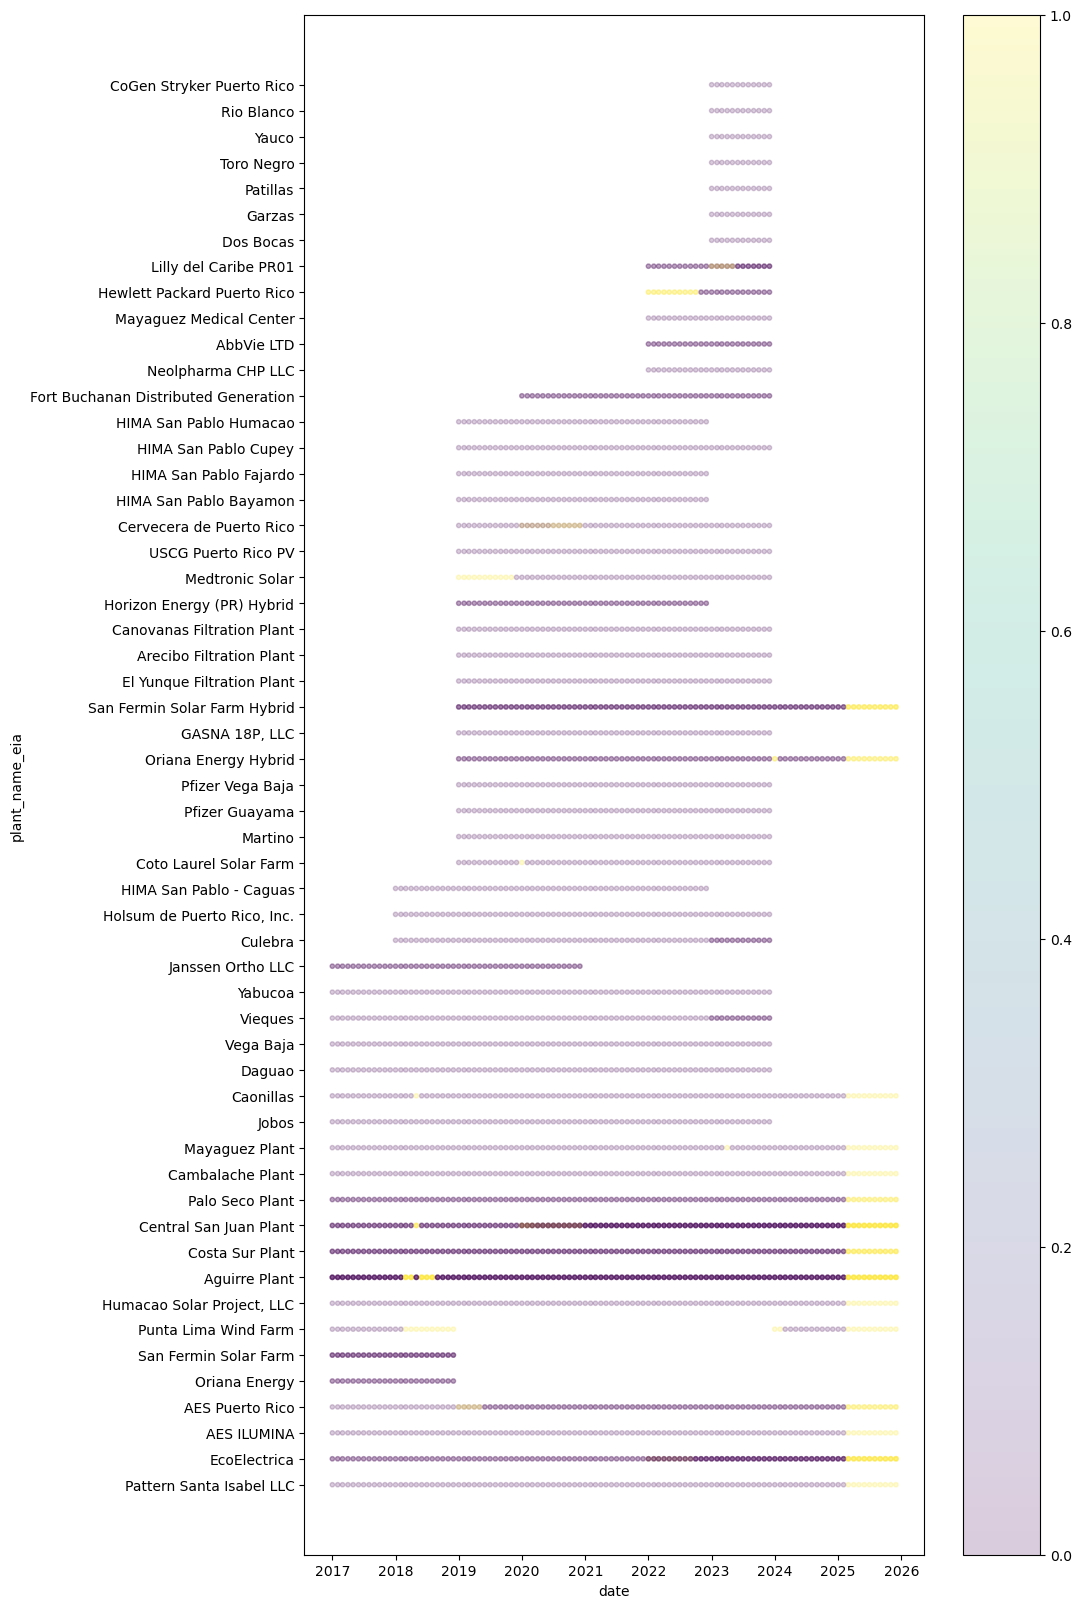

In [13]:
## some investigation into NA values
clean_index_cols = ["date", "energy_source_code", "prime_mover_code", "plant_id_eia", "plant_name_eia", "fuel_unit"]
pp = pr_gen_fuel_clean.set_index(clean_index_cols).isna().all(axis=1).reset_index().rename(columns={0: "isna"}).loc[:, ["date", "plant_name_eia", "isna"]]

pp.plot.scatter(x="date", y="plant_name_eia", c=pp["isna"].astype(int), colormap="viridis", s=10, alpha=0.2, figsize=(10, 20))

# it turns out that after 2025-03-01 there's a pile of NAs, and many plants have multiple generators, some of which report as all-NA while their sibling generators are reporting non-NA values
# though Aguirre Plant and Hewlett Packard Puerto Rico seem to have actual stretches of all-NA time that might be wroth dropping.

In [14]:
### annual table

pr_gen_fuel_annual = pr_gen_fuel.loc[
    :,
    index_cols + ["total_fuel_consumption_mmbtu", "total_fuel_consumption_quantity", "total_net_generation_mwh"]
]

In [15]:
### output
pr_gen_fuel_final.to_parquet("../data/pr_gen_fuel_monthly.parquet")
pr_gen_fuel_annual.to_parquet("../data/pr_gen_fuel_annual.parquet")
pr_plant_frame.to_parquet("../data/pr_plant_frame.parquet")